In [89]:
%matplotlib inline
import pandas as pd
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os.path
import sys
import numpy as np


In [84]:
# Define set of all parameters and meta-parameters
    parameters = {    
    "delta_schooling":[0.5],
        "xi":[0, 30 * 37199.03, 140 * 37199.03],
        "icus":[3000],
        "tests":[0],
        "frequencies":[(7,14)],
        "eta":[0.1, 0]
    }
    
    meta_parameters = {
        "trust_region_radius":[0,0.05,0.1,0.2,0.4,0.6],
        "max_inner_iterations_mult":[1, 1.5, 2],
        "initial_uhat":["dynamic_gradient", "full_lockdown", "full_open"]
    }
    
    n_days = 90
    groups = "all"


In [85]:
# Add all data into one big pandas dataframe

ls = []

for delta in parameters["delta_schooling"]:
    for xi in parameters["xi"]:
        for icus in parameters["icus"]:
            for tests in parameters["tests"]:
                for freq in parameters["frequencies"]:
                    for eta in parameters["eta"]:
                        for initial_uhat in meta_parameters["initial_uhat"]:
                            with open(f"testing_outputs_ndays={n_days}_eta={eta}_tests={tests}_xi={xi*10}_freq={freq[1]}_groups={groups}_initial_uhat={initial_uhat}.csv", "r") as file:
                                df = pd.read_csv(file, header=None, names=["radius", "factor", "num_iterations", "reward", "time"])
                            if len(df) == 0:
                                print(file.name)
                            df["delta"] = delta
                            df["xi"] = xi
                            df["icus"] = icus
                            df["tests"] = tests
                            df["freq"] = freq[1]
                            df["eta"] = eta
                            df["initial_uhat"] = initial_uhat
                            ls.append(df)

all_data = pd.concat(ls, ignore_index=True)


In [55]:
# First, look for each combination of parameters what combination of meta-param achieves the best rewards

for delta in parameters["delta_schooling"]:
    for xi in parameters["xi"]:
        for icus in parameters["icus"]:
            for tests in parameters["tests"]:
                for freq in parameters["frequencies"]:
                    for eta in parameters["eta"]:
                        maximum_reward = all_data[(all_data.delta == delta) 
                                                 & (all_data.xi == xi) 
                                                 & (all_data.icus == icus)
                                                 & (all_data.tests == tests) 
                                                 & (all_data.freq == freq[1])
                                                 & (all_data.eta == eta)].reward.max()
                        print(f"For xi={xi} and eta={eta}, the maximum reward is: {maximum_reward}")
                        print(f"And these are the meta-parameters that achieve it:")
                        print("Observe that radius == 0 implies that the solution follows the initial uhat")
                        print(all_data[all_data.reward == maximum_reward])
                        print("")

For xi=0 and eta=0.1, the maximum reward is: 54293211.26175425
And these are the meta-parameters that achieve it:
Observe that radius == 0 implies that the solution follows the initial uhat
    radius  factor  num_iterations        reward         time  delta   xi  \
3      0.2     1.0             5.0  5.429321e+07  3706.690063    0.5  0.0   
10     0.2     1.5             7.5  5.429321e+07  4080.882481    0.5  0.0   
11     0.2     2.0            10.0  5.429321e+07  4156.937640    0.5  0.0   

    icus  tests  freq  eta      initial_uhat  
3   3000      0    14  0.1  dynamic_gradient  
10  3000      0    14  0.1  dynamic_gradient  
11  3000      0    14  0.1  dynamic_gradient  

For xi=0 and eta=0, the maximum reward is: 56136871.74392151
And these are the meta-parameters that achieve it:
Observe that radius == 0 implies that the solution follows the initial uhat
     radius  factor  num_iterations        reward          time  delta   xi  \
49     0.00     1.0        0.000000  5.613687

Notice above that for any combination of parameters we achieve the maximum reward for some combination of meta_param

In [86]:
# Now we'll define the ratio of the rewards wrt to the maximum reward 

for delta in parameters["delta_schooling"]:
    for xi in parameters["xi"]:
        for icus in parameters["icus"]:
            for tests in parameters["tests"]:
                for freq in parameters["frequencies"]:
                    for eta in parameters["eta"]:
                        maximum_reward = all_data[(all_data.delta == delta) 
                                                 & (all_data.xi == xi) 
                                                 & (all_data.icus == icus)
                                                 & (all_data.tests == tests) 
                                                 & (all_data.freq == freq[1])
                                                 & (all_data.eta == eta)].reward.max()
                        
                        all_data.loc[(all_data.delta == delta)
                                                 & (all_data.xi == xi) 
                                                 & (all_data.icus == icus)
                                                 & (all_data.tests == tests) 
                                                 & (all_data.freq == freq[1])
                                                 & (all_data.eta == eta), "FractionalReward"] = all_data[(all_data.delta == delta) 
                                                 & (all_data.xi == xi) 
                                                 & (all_data.icus == icus)
                                                 & (all_data.tests == tests) 
                                                 & (all_data.freq == freq[1])
                                                 & (all_data.eta == eta)].reward / maximum_reward


Meta Param: radius = 0, factor = 1, num iterations = 0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9987404821014148, 1.0, 0.9841469575663407, 0.9787632453405194, 0.9029323852644886, 0.9776427558478772]
Histogram of Fractional Rewards:


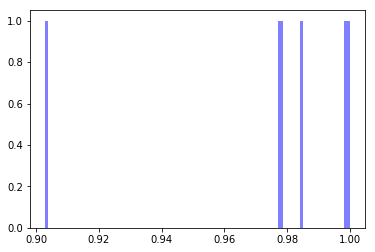

Meta Param: radius = 0, factor = 1, num iterations = 0, initia uhat = full_lockdown
List of Fractional Rewards: [0.2903372109795281, 0.28080188730086986, 0.23192030059507848, 0.21231267334949205, -1.0941790156556364, -0.8608990141389522]
Histogram of Fractional Rewards:


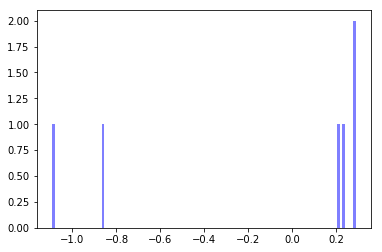

Meta Param: radius = 0, factor = 1, num iterations = 0, initia uhat = full_open
List of Fractional Rewards: [0.9494812689463952, 0.9182981794771456, -1.3195006322791651, -1.2079438755758476, -35.49309823801783, -27.925936107938675]
Histogram of Fractional Rewards:


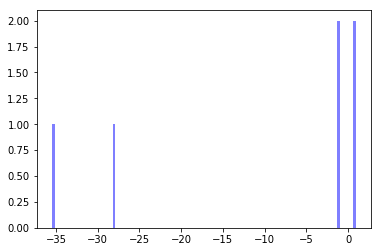

Meta Param: radius = 0, factor = 1.5, num iterations = 0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9987404821014148, 1.0, 0.9841469575663407, 0.9787632453405194, 0.9029323852644886, 0.9776427558478772]
Histogram of Fractional Rewards:


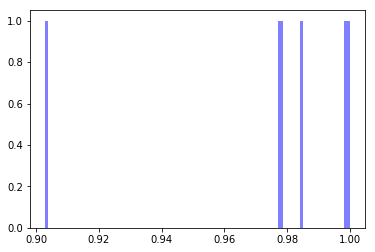

Meta Param: radius = 0, factor = 1.5, num iterations = 0, initia uhat = full_lockdown
List of Fractional Rewards: [0.2903372109795281, 0.28080188730086986, 0.23192030059507848, 0.21231267334949205, -1.0941790156556364, -0.8608990141389522]
Histogram of Fractional Rewards:


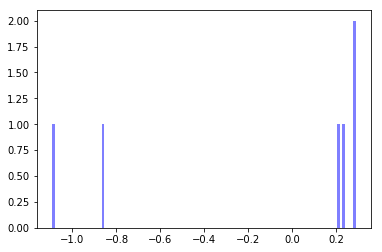

Meta Param: radius = 0, factor = 1.5, num iterations = 0, initia uhat = full_open
List of Fractional Rewards: [0.9494812689463952, 0.9182981794771456, -1.3195006322791651, -1.2079438755758476, -35.49309823801783, -27.925936107938675]
Histogram of Fractional Rewards:


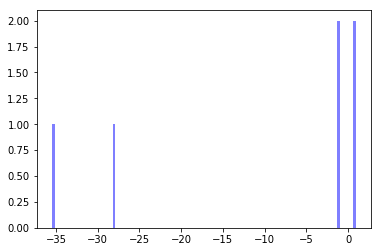

Meta Param: radius = 0, factor = 2, num iterations = 0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9987404821014148, 1.0, 0.9841469575663407, 0.9787632453405194, 0.9029323852644886, 0.9776427558478772]
Histogram of Fractional Rewards:


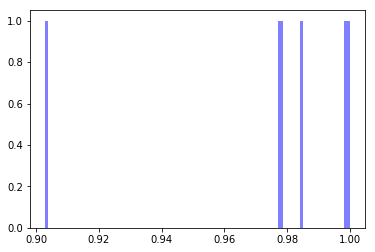

Meta Param: radius = 0, factor = 2, num iterations = 0, initia uhat = full_lockdown
List of Fractional Rewards: [0.2903372109795281, 0.28080188730086986, 0.23192030059507848, 0.21231267334949205, -1.0941790156556364, -0.8608990141389522]
Histogram of Fractional Rewards:


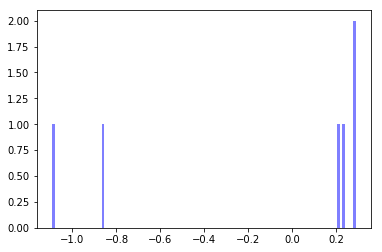

Meta Param: radius = 0, factor = 2, num iterations = 0, initia uhat = full_open
List of Fractional Rewards: [0.9494812689463952, 0.9182981794771456, -1.3195006322791651, -1.2079438755758476, -35.49309823801783, -27.925936107938675]
Histogram of Fractional Rewards:


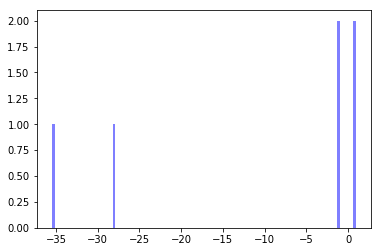

Meta Param: radius = 0.05, factor = 1, num iterations = 20.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9998391765660253, 1.0, 0.9929778620598274, 1.0, 0.989962052146527, 1.0]
Histogram of Fractional Rewards:


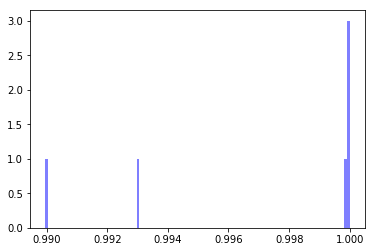

Meta Param: radius = 0.05, factor = 1, num iterations = 20.0, initia uhat = full_lockdown
List of Fractional Rewards: [0.9970920506348105, 1.0, 0.9956897982061264, 0.998661110608038, 0.961876165039957, 0.9743971549072803]
Histogram of Fractional Rewards:


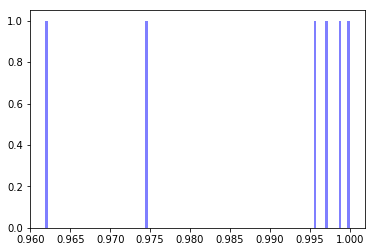

Meta Param: radius = 0.05, factor = 1, num iterations = 20.0, initia uhat = full_open
List of Fractional Rewards: [0.9964246002643651, 1.0, 0.9960312922340072, 0.9951455170701691, 0.9692229006431379, 0.9690957451478249]
Histogram of Fractional Rewards:


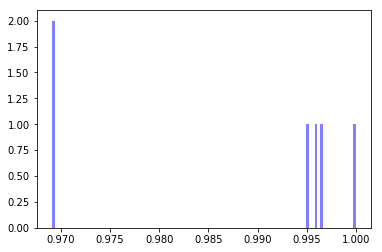

Meta Param: radius = 0.05, factor = 1.5, num iterations = 30.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9998391765660253, 1.0, 0.9929778620598274, 1.0, 0.98979063708076, 1.0]
Histogram of Fractional Rewards:


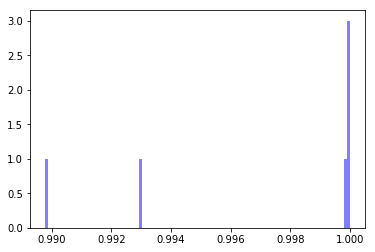

Meta Param: radius = 0.05, factor = 1.5, num iterations = 30.0, initia uhat = full_lockdown
List of Fractional Rewards: [0.996807454103071, 1.0, 0.9953524959193193, 0.9987344779977078, 0.9576885089162613, 0.9798012246881883]
Histogram of Fractional Rewards:


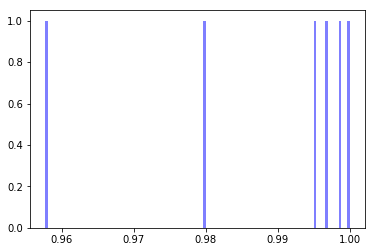

Meta Param: radius = 0.05, factor = 1.5, num iterations = 30.0, initia uhat = full_open
List of Fractional Rewards: [0.9972060494235498, 1.0, 0.998589956987499, 0.9985437722545695, 0.9831934871982039, 0.9819019572583371]
Histogram of Fractional Rewards:


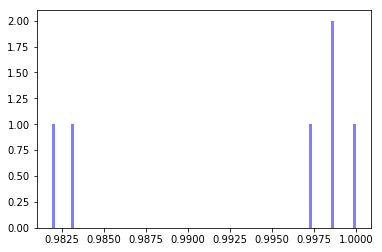

Meta Param: radius = 0.05, factor = 2, num iterations = 40.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9998391765660253, 1.0, 0.9929778620598274, 1.0, 0.98979063708076, 1.0]
Histogram of Fractional Rewards:


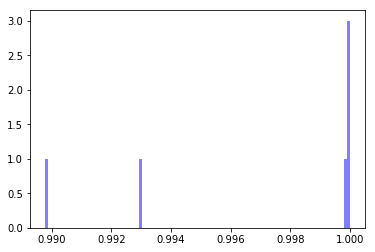

Meta Param: radius = 0.05, factor = 2, num iterations = 40.0, initia uhat = full_lockdown
List of Fractional Rewards: [0.996807454103071, 1.0, 0.9953524959193193, 0.9987344779977078, 0.9576885089162613, 0.9798012246881883]
Histogram of Fractional Rewards:


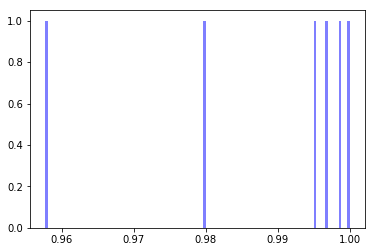

Meta Param: radius = 0.05, factor = 2, num iterations = 40.0, initia uhat = full_open
List of Fractional Rewards: [0.9972060494235498, 1.0, 0.9986545361054376, 0.9985892083087052, 0.983471469566115, 0.9819019572583375]
Histogram of Fractional Rewards:


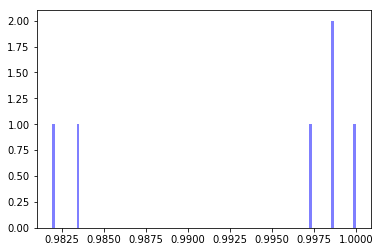

Meta Param: radius = 0.1, factor = 1, num iterations = 10.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9963793833497858, 0.9989009550611769, 1.0, 0.9999311731013811]
Histogram of Fractional Rewards:


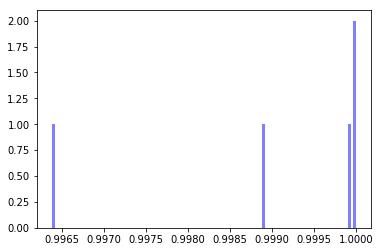

Meta Param: radius = 0.1, factor = 1, num iterations = 10.0, initia uhat = full_lockdown
List of Fractional Rewards: [0.9961245545593044, 1.0, 0.9936492650492463, 0.998445554070719, 0.9547927450532573, 0.9802792664910228]
Histogram of Fractional Rewards:


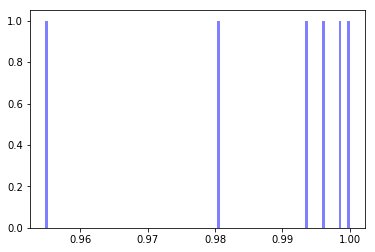

Meta Param: radius = 0.1, factor = 1, num iterations = 10.0, initia uhat = full_open
List of Fractional Rewards: [0.9964007770341502, 0.9964007770341502, 0.999999991709551, 0.9970896548834484, 0.9932728879574293, 0.937454029196201, 0.9713500412503853]
Histogram of Fractional Rewards:


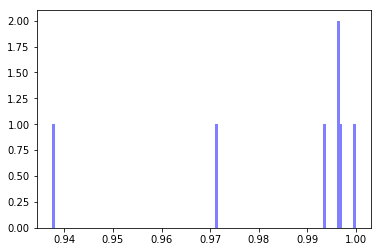

Meta Param: radius = 0.1, factor = 1.5, num iterations = 15.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9971399980826839, 0.9989009550611769, 1.0, 0.9999311731013811]
Histogram of Fractional Rewards:


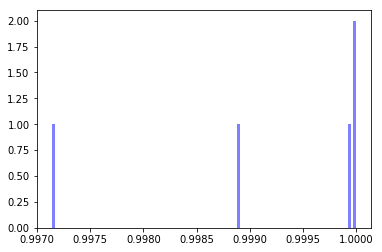

Meta Param: radius = 0.1, factor = 1.5, num iterations = 15.0, initia uhat = full_lockdown
List of Fractional Rewards: [0.9954895486426549, 1.0, 0.9871800852749246, 0.9986531141150792, 0.9521682175718887, 0.9802792664910228]
Histogram of Fractional Rewards:


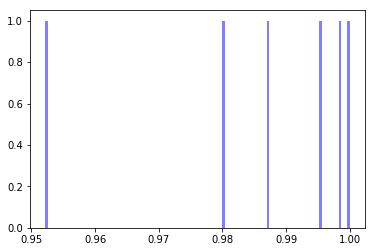

Meta Param: radius = 0.1, factor = 1.5, num iterations = 15.0, initia uhat = full_open
List of Fractional Rewards: [0.9963503380801897, 1.0, 0.9950381538825219, 0.9986330012760928, 0.9408641463634508, 0.9883286450809183]
Histogram of Fractional Rewards:


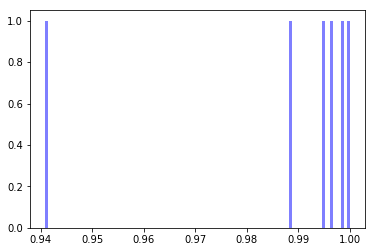

Meta Param: radius = 0.1, factor = 2, num iterations = 20.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 0.9971399980826839, 0.9989009550611769, 1.0, 0.9999311731013811]
Histogram of Fractional Rewards:


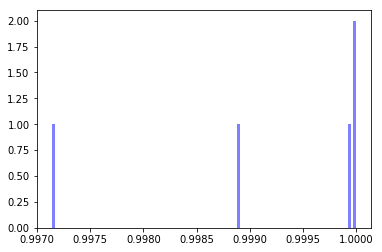

Meta Param: radius = 0.1, factor = 2, num iterations = 20.0, initia uhat = full_lockdown
List of Fractional Rewards: [0.9954895486426549, 1.0, 0.9871800852749246, 0.9986531141150792, 0.9521682175718887, 0.9872197219190595]
Histogram of Fractional Rewards:


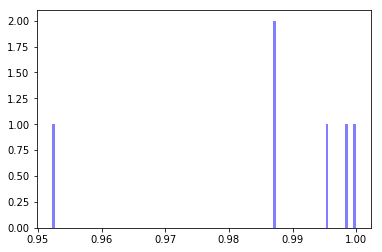

Meta Param: radius = 0.1, factor = 2, num iterations = 20.0, initia uhat = full_open
List of Fractional Rewards: [0.9969726561473986, 1.0, 0.9952930676943437, 0.9986330012760928, 0.8754875112206709, 0.9883286450809188]
Histogram of Fractional Rewards:


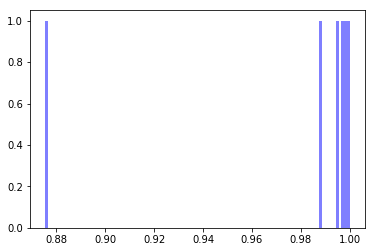

Meta Param: radius = 0.2, factor = 1, num iterations = 5.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 1.0, 1.0, 0.9980255992216709, 0.9796573458846953, 0.9958753883317757]
Histogram of Fractional Rewards:


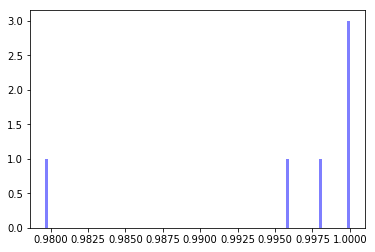

Meta Param: radius = 0.2, factor = 1, num iterations = 5.0, initia uhat = full_lockdown
List of Fractional Rewards: [1.0, 0.9657596956792998, 0.9957744270684711, 0.9557734797367486, 0.950392611393033]
Histogram of Fractional Rewards:


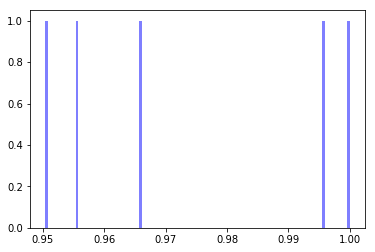

Meta Param: radius = 0.2, factor = 1, num iterations = 5.0, initia uhat = full_open
List of Fractional Rewards: [0.9958462939874569, 0.9999999933251627, 0.9935116592544906, 0.993428069971022, 0.8391726121373332, 0.9485716328135848]
Histogram of Fractional Rewards:


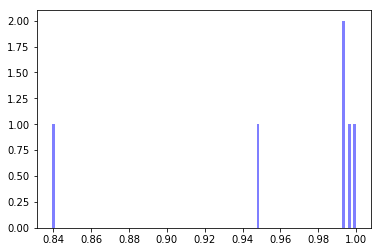

Meta Param: radius = 0.2, factor = 1.5, num iterations = 7.5, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 1.0, 0.999470550404227, 0.9982602165735787, 0.9787197888229675, 0.9958753883317757]
Histogram of Fractional Rewards:


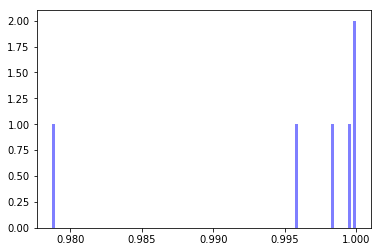

Meta Param: radius = 0.2, factor = 1.5, num iterations = 7.5, initia uhat = full_lockdown
List of Fractional Rewards: [0.9974877377181505, 1.0, 0.9956070607768317, 0.9988372702546707, 0.9613307536558451, 0.9834302445034326]
Histogram of Fractional Rewards:


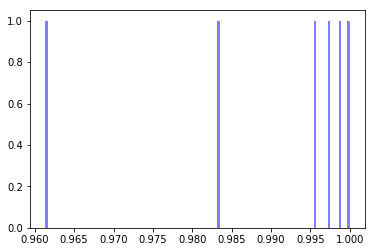

Meta Param: radius = 0.2, factor = 1.5, num iterations = 7.5, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9777694535783358, 0.9957929705000739, 0.8391358779695033, 0.9729332057634118]
Histogram of Fractional Rewards:


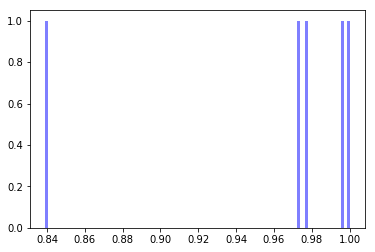

Meta Param: radius = 0.2, factor = 2, num iterations = 10.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [1.0, 1.0, 0.999470550404227, 0.9982602165735787, 0.9787197888229675, 0.9958753883317757]
Histogram of Fractional Rewards:


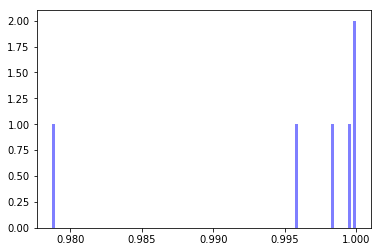

Meta Param: radius = 0.2, factor = 2, num iterations = 10.0, initia uhat = full_lockdown
List of Fractional Rewards: [0.9974877377181505, 1.0, 0.9956070607768317, 0.9988372702546707, 0.9613307536558451, 0.9834302445034326]
Histogram of Fractional Rewards:


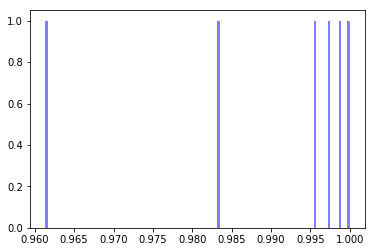

Meta Param: radius = 0.2, factor = 2, num iterations = 10.0, initia uhat = full_open
List of Fractional Rewards: [1.0, 0.9777694535783358, 0.998500374497869, 0.9729332057634118]
Histogram of Fractional Rewards:


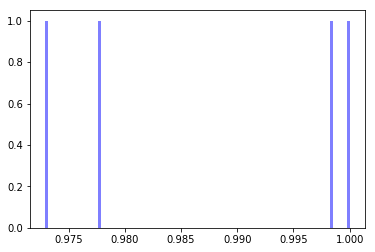

Meta Param: radius = 0.4, factor = 1, num iterations = 2.5, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9987768410525938, 1.0, 0.9979750289678255, 0.997968939109723, 0.9520448218543434, 0.9908131386147279]
Histogram of Fractional Rewards:


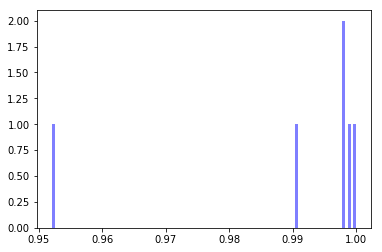

Meta Param: radius = 0.4, factor = 1, num iterations = 2.5, initia uhat = full_lockdown
List of Fractional Rewards: [0.996595089484378, 1.0, 0.9988886268880123, 0.9933564205594893, 0.9100842402115592, 0.8739800608843334]
Histogram of Fractional Rewards:


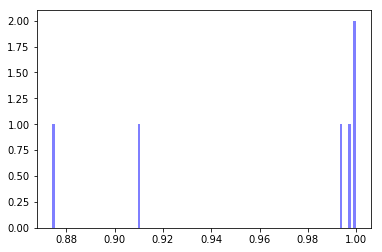

Meta Param: radius = 0.4, factor = 1, num iterations = 2.5, initia uhat = full_open
List of Fractional Rewards: [0.9949508001893304, 1.0, 0.9978758419454394, 0.9928603433419132, 0.725380712605248, 0.9157244905976237]
Histogram of Fractional Rewards:


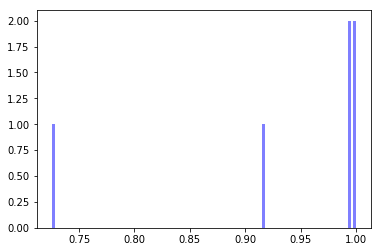

Meta Param: radius = 0.4, factor = 1.5, num iterations = 3.75, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9987768410525936, 1.0, 0.9979750289678255, 0.9982172566913272, 0.9520448218543434, 0.9908131386147279]
Histogram of Fractional Rewards:


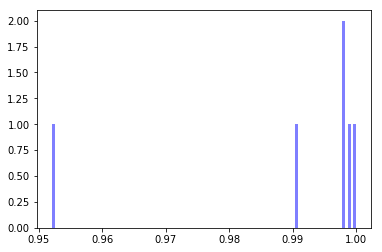

Meta Param: radius = 0.4, factor = 1.5, num iterations = 3.75, initia uhat = full_lockdown
List of Fractional Rewards: [0.9975390528149971, 1.0, 0.9914450014684111, 0.9982782068164472, 0.9353521341084313, 0.9375908387715743]
Histogram of Fractional Rewards:


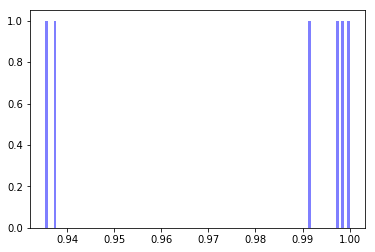

Meta Param: radius = 0.4, factor = 1.5, num iterations = 3.75, initia uhat = full_open
List of Fractional Rewards: [0.9949508001893304, 1.0, 0.9945521519940246, 0.9934054592221147, 0.7253807126052472, 0.8980259123922592]
Histogram of Fractional Rewards:


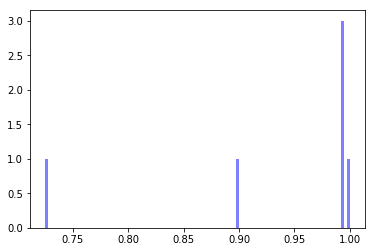

Meta Param: radius = 0.4, factor = 2, num iterations = 5.0, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9987768410525936, 1.0, 0.9979750289678255, 0.9982172566913272, 0.9520448218543434, 0.9908131386147279]
Histogram of Fractional Rewards:


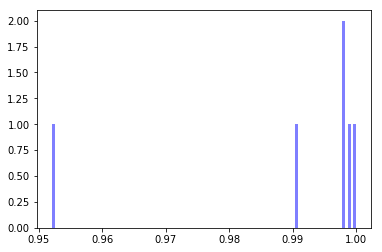

Meta Param: radius = 0.4, factor = 2, num iterations = 5.0, initia uhat = full_lockdown
List of Fractional Rewards: [0.9975390528149971, 1.0, 0.9914450014684111, 0.9982782068164472, 0.9353521341084313, 0.9375908387715743]
Histogram of Fractional Rewards:


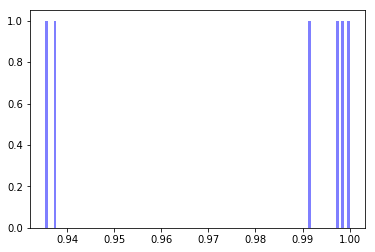

Meta Param: radius = 0.4, factor = 2, num iterations = 5.0, initia uhat = full_open
List of Fractional Rewards: [0.9949508001893304, 1.0, 0.985796713782264, 0.9981780299183645, 0.7253807126052472, 0.978434143239304]
Histogram of Fractional Rewards:


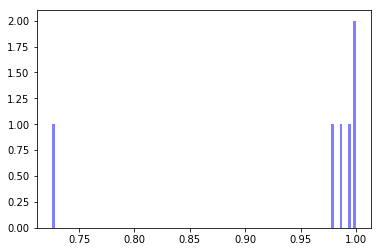

Meta Param: radius = 0.6, factor = 1, num iterations = 1.6666666666666667, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9969298598953825, 1.0, 0.9867509909785395, 0.9971310058650399, 0.9067806921142141, 0.9865197211362766]
Histogram of Fractional Rewards:


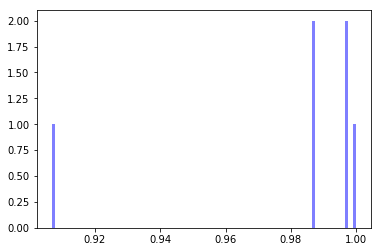

Meta Param: radius = 0.6, factor = 1, num iterations = 1.6666666666666667, initia uhat = full_lockdown
List of Fractional Rewards: [0.9995132587639111, 1.0, 0.9257016732728479, 0.9934008588807429, 0.6832360923905982, 0.9478665600906535]
Histogram of Fractional Rewards:


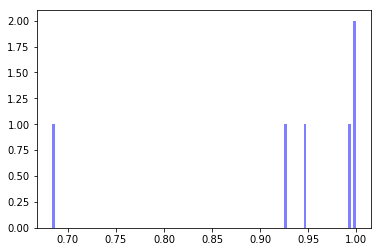

Meta Param: radius = 0.6, factor = 1, num iterations = 1.6666666666666667, initia uhat = full_open
List of Fractional Rewards: [0.992897356170655, 0.9990174009478607, 0.862959492493684, 0.9486614157305935, -0.6838683412314213, 0.2151980639961966]
Histogram of Fractional Rewards:


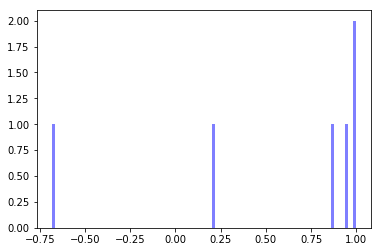

Meta Param: radius = 0.6, factor = 1.5, num iterations = 2.5, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9969298598953825, 1.0, 0.9867509909785395, 0.9971310058650399, 0.9067806921142141, 0.9865197211362766]
Histogram of Fractional Rewards:


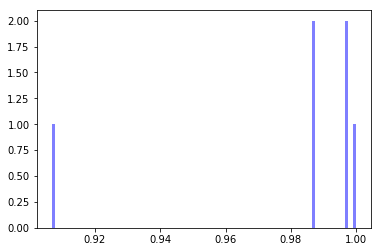

Meta Param: radius = 0.6, factor = 1.5, num iterations = 2.5, initia uhat = full_lockdown
List of Fractional Rewards: [0.9995132587639111, 1.0, 0.9257016732728479, 0.9934008588807429, 0.6832360923905982, 0.9478665600906535]
Histogram of Fractional Rewards:


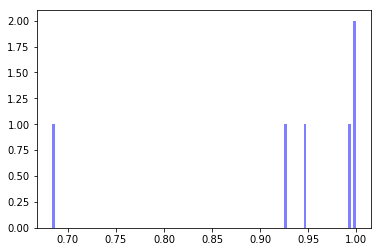

Meta Param: radius = 0.6, factor = 1.5, num iterations = 2.5, initia uhat = full_open
List of Fractional Rewards: [0.992897356170655, 1.0, 0.862959492493684, 0.9914617856533338, -0.6838683412314213, 0.9236025118544846]
Histogram of Fractional Rewards:


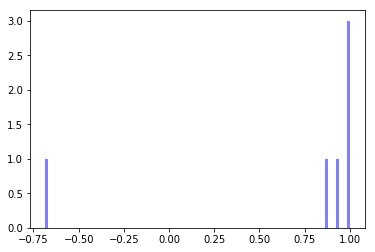

Meta Param: radius = 0.6, factor = 2, num iterations = 3.3333333333333335, initia uhat = dynamic_gradient
List of Fractional Rewards: [0.9969298598953825, 1.0, 0.9867509909785395, 0.9971310058650399, 0.9068475639711557, 0.9865197211362766]
Histogram of Fractional Rewards:


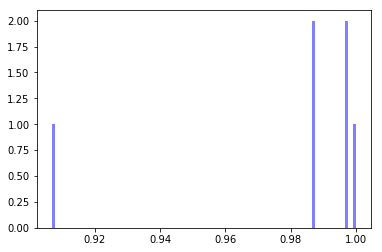

Meta Param: radius = 0.6, factor = 2, num iterations = 3.3333333333333335, initia uhat = full_lockdown
List of Fractional Rewards: [0.9980223518028353, 1.0, 0.9297271020956778, 0.9934008588807429, 0.6832360923905872, 0.9478665600906535]
Histogram of Fractional Rewards:


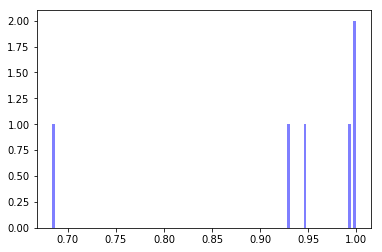

Meta Param: radius = 0.6, factor = 2, num iterations = 3.3333333333333335, initia uhat = full_open
List of Fractional Rewards: [0.992897356170655, 1.0, 0.862959492493684, 0.997705589107255, -0.6838683412314213]
Histogram of Fractional Rewards:


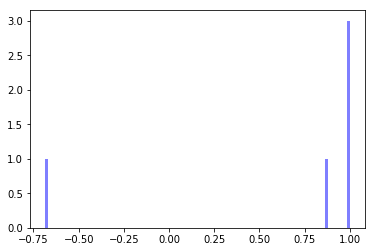

In [96]:
# Now for each combination of meta-parameters we can plot a histogram of the fractional rewards.
# This should give an idea of how good the meta-parameters are for all the instances.

meta_parameters = {
        "trust_region_radius":[0,0.05,0.1,0.2,0.4,0.6],
        "max_inner_iterations_mult":[1, 1.5, 2],
        "initial_uhat":["dynamic_gradient", "full_lockdown", "full_open"]
    }
    

for radius in meta_parameters["trust_region_radius"]:
    for factor in meta_parameters["max_inner_iterations_mult"]:
        for initial_uhat in meta_parameters["initial_uhat"]:
            print(f"Meta Param: radius = {radius}, factor = {factor}, num iterations = {factor/radius if radius>0 else 0}, initia uhat = {initial_uhat}")
            frac_rewards_list = list(all_data.loc[(all_data.radius==radius) & (all_data.factor==factor) & (all_data.initial_uhat==initial_uhat), "FractionalReward"])
            print(f"List of Fractional Rewards: {frac_rewards_list}")
            num_bins = 110
            print("Histogram of Fractional Rewards:")
            plt.hist(frac_rewards_list, num_bins, facecolor='blue', alpha=0.5)
            plt.show()